In [ ]:
!unzip /content/drive/MyDrive/Face_Dataset/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0022.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0023.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0024.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0025.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0026.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0027.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0028.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0029.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Si

In [ ]:
from __future__ import absolute_import,division,print_function,unicode_literals

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import time
from IPython import display
import glob
import imageio
import PIL
import time
import os

In [ ]:
# from PIL import Image
# def load_images_from_folder(folder_path):
#     train_images = []

#     for filename in os.listdir(folder_path):
#         if filename.endswith('.jpg') or filename.endswith('.png'):
#             image_path = os.path.join(folder_path, filename)
#             with Image.open(image_path) as img:
#                 # img_resized = img.resize((28, 28)).convert('L')  # Resize and convert to grayscale
#                 train_images.append(np.array(img))

#     return np.array(train_images)

# folder_path = "/content/thumbnails128x128"
# train_images = load_images_from_folder(folder_path)


In [ ]:
from PIL import Image

def load_images_from_folder(folder_path):
    train_images = []
    i = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for filename in filenames:
            if i > 5000:
                break
            if filename.endswith('.jpg') or filename.endswith('.png'):
                i += 1
                image_path = os.path.join(dirpath, filename)
                with Image.open(image_path) as img:
                    img = img.resize((128,128))
                    train_images.append(np.array(img))

    return np.array(train_images)



folder_path = "/content/lfw-deepfunneled/lfw-deepfunneled"
train_images = load_images_from_folder(folder_path)


In [ ]:
# (train_images,train_labels) , (_,_) = tf.keras.datasets.fashion_mnist.load_data()

In [ ]:
train_images.shape

(5001, 128, 128, 3)

In [ ]:
# # # Reshaping the data , generally the shape should be (_,_,_,_)
# train_images = train_images.reshape(train_images.shape[0],128,128,3).astype('float32')
# train_images.shape

In [ ]:
train_images = (train_images - 127.5) / 127.5   #Normalize the images to [-1,1]

In [ ]:
train_images.min() , train_images.max()

(-1.0, 1.0)

In [ ]:
BUFFER_SIZE = 5001
BATCH_SIZE = 256

In [ ]:
#Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

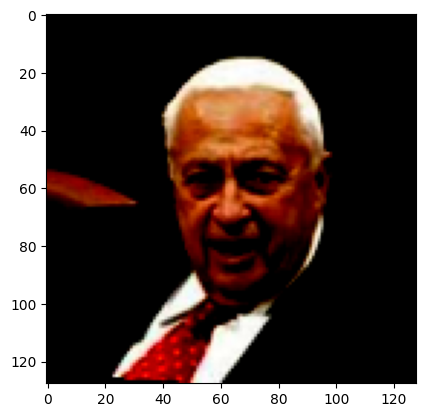

In [ ]:
plt.imshow(train_images[100])

# Build the Generator

* Generator takes random noise signal and outputs img

* It is trying to generate fake images to fool the discriminator
* Labels are:
    * Label = 1.0 indicates real image
    * Label - 0.0 indicates fake image

* The generator uses Conv2DTranspose layers to create image from seed of noise
* The seed is fet to a Dense Layer and upsampled several times until final image size of 28x28x1 is achieved.

In [ ]:
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(32*32*256,use_bias=False,input_shape=(100,))) #12544
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((32, 32, 256)))

  # Because we used same padding and stride = 1 , the output shape is same as input i.e 32 x 32 x 128
  model.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  # Because we used same padding and stride = 2 , the output shape is double as input i.e 64 x 64 x 64
  model.add(layers.Conv2DTranspose(64 , (5,5), strides=(2,2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  # Because we used same padding and stride = 2 , the output shape is double as input i.e 128 x 128 x 3
  model.add(layers.Conv2DTranspose(3 , (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
  model.summary()

  return model

In [ ]:
generator = make_generator_model()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 262144)            26214400  
                                                                 
 batch_normalization_7 (Bat  (None, 262144)            1048576   
 chNormalization)                                                
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 262144)            0         
                                                                 
 reshape_2 (Reshape)         (None, 32, 32, 256)       0         
                                                                 
 conv2d_transpose_7 (Conv2D  (None, 32, 32, 128)       819200    
 Transpose)                                                      
                                                                 
 batch_normalization_8 (Bat  (None, 32, 32, 128)      

In [ ]:
# Lets test the network with random noise

noise = tf.random.normal([1,100])
generated_img = generator(noise, training = False)
generated_img.shape

TensorShape([1, 128, 128, 3])

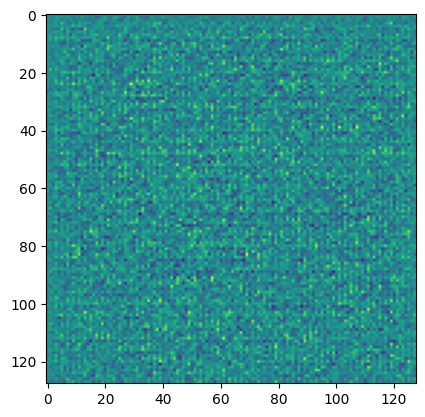

In [ ]:
plt.imshow(generated_img[0,:,:,0])

# Build the discriminator

In [ ]:
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5,5), strides= (2,2), padding='same', input_shape=[128,128,3]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5,5), strides= (2,2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))
  model.summary()

  return model

In [ ]:
discriminator = make_discriminator_model()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        4864      
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 64, 64, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 64, 64, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 128)       204928    
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                                 
 dropout_5 (Dropout)         (None, 32, 32, 128)       0         
                                                                 
 flatten_2 (Flatten)         (None, 131072)           

# Define loss function for both the networks

In [ ]:
# This computes the difference between the model predictions and true label
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
# It indicates how well the discriminator is able to distinguish real and fake images
# It compares the discriminator predictionson real images to array of 1s,
# and the discriminators predictions on fake images to an array of 0s

def discriminator_loss(real_output,fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output),real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
  total_loss = real_loss + fake_loss

  return total_loss

In [ ]:
#Generator loss quantifies how well it was able to trick the discriminator
# If generator is performing well, the discriminator will classify the fake images as real
# Here we will compare the discriminators descision on the generated images to an array of 1s
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output),fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
# keeping track while training
checkpoint_dir = '/content'
checkpoint_prefix =  os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator = generator,
                                 discriminator=discriminator)

# Train the Model

In [ ]:
EPOCHS = 5000
noise_dim = 100
num_example_to_generate = 1

seed = tf.random.normal([num_example_to_generate,noise_dim])

In [ ]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape , tf.GradientTape() as disc_tape:

    # 1. Call the generator and feed the noise
    generated_images =  generator(noise,training=True)

    # 2. Pass the fake and real ones to discriminator
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images,training=True)

    # 3. Calculate loss of both generator and discriminator
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output,fake_output)

  # 4. Calculate the gradients of both the models
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  # 5. Apply the optimizers and update weight
  generator_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))


In [ ]:
def generate_and_save_images(model,epoch,test_input):
  predictions = model(test_input,training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    # plt.subplot(128,128,i+1)
    plt.imshow(((predictions[i] * 127.5 + 127.5).numpy().astype(np.uint8)))
    plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,epoch+1,seed)

    # Save the model every 15 epochs
    if (epoch+1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch+1, time.time() - start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,epochs,seed)


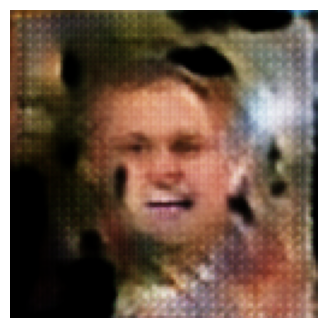

Time for epoch 569 is 15.646734237670898 sec


In [ ]:
%%time
train(train_dataset,EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

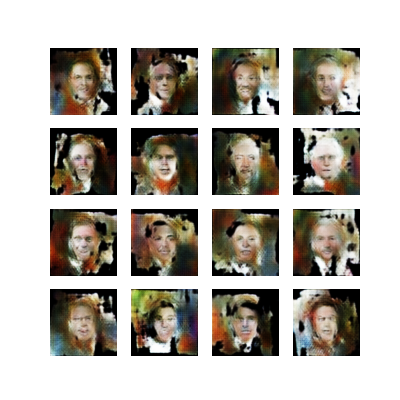

In [ ]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS)